# GNN Model Training

This notebook trains the GNN model as well as two baseline models (logistic regression, edge-only MLP neural network) for performance comparison.

The estimated parameters are saved in `{model_name}_multihead_best.pt`.

### 1. Import data and feature normalization

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Load data and convert NaN features to 0
BASE = Path("/Users/haozhangao/Desktop/RecSys Research/KuaiRec 2.0/data/processed/")

DATA_PATH = BASE / "gnn_data_tiny.pt"
# DATA_PATH = BASE / "gnn_data.pt"
data = torch.load(DATA_PATH)

edge_index = data["edge_index"]       # [2, E]
edge_attr  = data["edge_attr"]        # [E, D_edge]
y_all      = data["y"]                # [E, 4]
train_idx  = data["train_idx"]
val_idx    = data["val_idx"]
test_idx   = data["test_idx"]
num_nodes  = data["num_nodes"]
D_edge     = data["num_edge_features"]
numeric_feature_cols = data["feature_names"]

edge_attr = torch.nan_to_num(edge_attr, nan=0.0)

print("edge_attr shape:", edge_attr.shape, "y_shape", y_all.shape)
print("NaN in edge_attr:", torch.isnan(edge_attr).any().item())

edge_attr shape: torch.Size([626395, 64]) y_shape torch.Size([626395, 4])
NaN in edge_attr: False


In [2]:
# Feature Normalization (compute mean and std on training set only)
with torch.no_grad():
    mu = edge_attr[train_idx].mean(dim=0, keepdim=True)
    std = edge_attr[train_idx].std(dim=0, keepdim=True)
    std[std < 1e-6] = 1.0

    edge_attr = (edge_attr - mu)  / std

In [3]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)
y_all = y_all.to(device)
train_idx  = train_idx.to(device)
val_idx    = val_idx.to(device)
test_idx   = test_idx.to(device)

### 2. Baseline model 1: Logistic Regression

In [4]:
# Baseline 1: logistic regression 

head_names = ["y_complete", "y_long", "y_rewatch", "y_neg"]

# Move tensors to CPU
edge_attr_np = edge_attr.detach().cpu().numpy()
y_np         = y_all.detach().cpu().numpy()
train_idx_np = np.asarray(train_idx.cpu())
val_idx_np   = np.asarray(val_idx.cpu())
test_idx_np  = np.asarray(test_idx.cpu())

# Build feature matrix and standardize
X_train = edge_attr_np[train_idx_np]
X_val   = edge_attr_np[val_idx_np]
X_test  = edge_attr_np[test_idx_np]

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std   = scaler.transform(X_val)
X_test_std  = scaler.transform(X_test)


for head_idx in range(len(head_names)):
    y_train = y_np[train_idx_np, head_idx]
    y_val   = y_np[val_idx_np,   head_idx]
    y_test  = y_np[test_idx_np,  head_idx]

    print("--------------------------------------------")
    print(f"Logistic Regression result for {head_names[head_idx]}:")
    print("--------------------------------------------")
    print("Train positives rate:", y_train.mean())
    print("Val   positives rate:", y_val.mean())
    print("Test  positives rate:", y_test.mean())
    
    log_reg = LogisticRegression(
    max_iter=1000,
    n_jobs=1,
    )
           
    log_reg.fit(X_train_std, y_train)

    train_probs = log_reg.predict_proba(X_train_std)[:, 1]
    val_probs   = log_reg.predict_proba(X_val_std)[:, 1]
    test_probs  = log_reg.predict_proba(X_test_std)[:, 1]

    train_auc = roc_auc_score(y_train, train_probs)
    val_auc   = roc_auc_score(y_val,   val_probs)
    test_auc  = roc_auc_score(y_test,  test_probs)
    
    print(f"Logistic baseline AUCs:")
    print(f"  train AUC = {train_auc:.4f}")
    print(f"  val   AUC = {val_auc:.4f}")
    print(f"  test  AUC = {test_auc:.4f}")
    print()
    # Inspect feature importance via logistic coefficients

    feature_names = numeric_feature_cols
    coef = log_reg.coef_.ravel()          # shape (D,)
    
    imp = pd.DataFrame({
        "feature": feature_names,
        "coef": coef
    })
    imp["abs_coef"] = imp["coef"].abs()
    
    # Top 20 by absolute coefficient
    imp_sorted = imp.sort_values("abs_coef", ascending=False)
    
    print("\nTop 20 most predictive features (by |coef|):")
    print(imp_sorted.head(20)[["feature", "coef"]])
    
    # If you also want to see the strongest negative vs positive separately:
    print("\nTop 10 features with positive coefficients:")
    print(imp_sorted[imp_sorted["coef"] > 0].head(10)[["feature", "coef"]])
    
    print("\nTop 10 features with negative coefficients:")
    print(imp_sorted[imp_sorted["coef"] < 0].head(10)[["feature", "coef"]])
    print()

--------------------------------------------
Logistic Regression result for y_complete:
--------------------------------------------
Train positives rate: 0.33711955
Val   positives rate: 0.33672312
Test  positives rate: 0.3394636
Logistic baseline AUCs:
  train AUC = 0.8268
  val   AUC = 0.8239
  test  AUC = 0.8297


Top 20 most predictive features (by |coef|):
                      feature      coef
44           i_video_duration -4.612000
52        hist_ema_y_complete  0.444310
60  hist_last_complete_author  0.374057
53            hist_ema_y_long  0.277467
61    hist_has_author_history -0.253496
57      hist_cat_ema_complete  0.135094
45    i_age_since_upload_days -0.046970
39              i_upload_type -0.041875
38               i_video_type -0.041218
54         hist_ema_y_rewatch -0.040980
0                    burst_id  0.037453
55             hist_ema_y_neg -0.036345
34    u_friend_user_num_log1p -0.032266
50               ctx_hour_cos  0.026199
11    u_friend_user_num_range  0.02

### 3. Baseline model 2: Edge-feature-only MLP feedforward NN

In [5]:
# Baseline 2: Edge-only feedforward NN (multi-layer perceptron, no graph structure)

class EdgeMLP(nn.Module):
    """
    Edge-only baseline MLP that predicts 4 edge-level scores using
    only edge features, without any graph structure.
    """
    def __init__(self, num_edge_features, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_edge_features, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 4),
        )

    def forward(self, edge_index, edge_attr):
        # ignore edge_index; just use edge features
        logits = self.net(edge_attr)      # [E, 4]
        return logits


    def encode_nodes(self, edge_index):
        """
        For API compatibility with GNN.
        """
        return None

    def score_edges(self, x, edge_index, edge_attr):
        """
        Node embedding x is ignored; kept only so train_step / eval_split work unchanged.
        """
        return self.forward(edge_index, edge_attr)

### 4. GNN model construction, training and evaluation functions

In [6]:
class GNN(nn.Module):
    """
    GNN that learns node embeddings with three GCN layers and predicts
    4 edge-level scores by feeding [h_src, h_dst, edge_attr] into an MLP.
    """
    def __init__(self, num_nodes, num_edge_features, hidden_dim=64):
        super().__init__()

        self.node_emb = nn.Embedding(num_nodes, hidden_dim)

        self.gcn1 = GCNConv(hidden_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.gcn3 = GCNConv(hidden_dim, hidden_dim)

        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * hidden_dim + num_edge_features, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )

    def encode_nodes(self, edge_index):
        x = self.node_emb.weight
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))
        x = F.relu(self.gcn3(x, edge_index))
        return x                    # [num_nodes, hidden_dim]

    def score_edges(self, x, edge_index, edge_attr):
        src, dst = edge_index
        h_src = x[src]
        h_dst = x[dst]

        h_edge = torch.cat([h_src, h_dst, edge_attr], dim=-1)
        logits = self.edge_mlp(h_edge)    # [E_batch, 4]
        return logits

In [7]:
@torch.no_grad()
def eval_split(idx, split_name="", batch_size=50000):
    """
    Evaluate the model on a given set of edges (train/val/test) and compute
    average loss plus per-head and mean ROC AUC. The edges are processed in
    batches to avoid storing all logits and activations in GPU memory at once.
    """
    model.eval()

    x = model.encode_nodes(edge_index)

    losses = []
    n_total = 0
    all_probs = []
    all_labels = []

    for start in range(0, idx.size(0), batch_size):
        end = min(start + batch_size, idx.size(0))
        batch_edges = idx[start:end]

        ei_batch = edge_index[:, batch_edges]
        ea_batch = edge_attr[batch_edges]
        y_batch  = y_all[batch_edges]                 # [B, 4]

        logits_batch = model.score_edges(x, ei_batch, ea_batch)  # [B, 4]
        loss_batch = criterion(logits_batch, y_batch)

        B = y_batch.size(0)
        losses.append(loss_batch.item() * B)
        n_total += B

        # detach before moving to numpy
        probs_batch = torch.sigmoid(logits_batch).detach().cpu().numpy()  # [B, 4]
        y_np_batch  = y_batch.detach().cpu().numpy()                      # [B, 4]

        all_probs.append(probs_batch)
        all_labels.append(y_np_batch)

    avg_loss = sum(losses) / max(n_total, 1)

    probs = np.concatenate(all_probs, axis=0)    # [N_split, 4]
    labels = np.concatenate(all_labels, axis=0)  # [N_split, 4]

    auc_per_head = []
    for h in range(labels.shape[1]):
        y_h = labels[:, h]
        p_h = probs[:, h]
        if np.all(y_h == 0) or np.all(y_h == 1):
            auc_h = float("nan")
        else:
            auc_h = roc_auc_score(y_h, p_h)
        auc_per_head.append(auc_h)

    valid_aucs = [a for a in auc_per_head if not np.isnan(a)]
    mean_auc = float(np.mean(valid_aucs)) if valid_aucs else float("nan")

    return avg_loss, auc_per_head, mean_auc


In [8]:
def train_step(batch_size=4096):
    """
    Perform one training update: sample a random mini-batch of training edges,
    compute their logits and BCE loss over 4 heads, backpropagate, and update
    model parameters. Mini-batching is used both for stochastic gradients and
    to keep memory usage manageable.
    """
    model.train()
    optimizer.zero_grad()

    # 1) GCN over full graph
    x = model.encode_nodes(edge_index)              # [num_nodes, hidden_dim]

    # 2) sample a mini-batch of training edges
    perm = torch.randint(
        low=0,
        high=train_idx.size(0),
        size=(batch_size,),
        device=device,
    )
    batch_edges = train_idx[perm]                   # [B]

    edge_index_batch = edge_index[:, batch_edges]   # [2, B]
    edge_attr_batch  = edge_attr[batch_edges]       # [B, D_edge]
    y_batch          = y_all[batch_edges]               # [B, 4]

    # 3) forward on this batch (4 logits per edge)
    logits_batch = model.score_edges(x, edge_index_batch, edge_attr_batch)  # [B, 4]

    # 4) BCE over all 4 heads
    loss = criterion(logits_batch, y_batch)

    loss.backward()
    optimizer.step()

    return float(loss.item())

### 5. Experiment on learning rate and batch size

In [9]:
import copy
import torch
import matplotlib.pyplot as plt

# Helper to (re)build GNN + optimizer for each run
def make_gnn_model(hidden_dim, lr):
    global model, optimizer, criterion

    model = GNN(
        num_nodes=num_nodes,
        num_edge_features=D_edge,
        hidden_dim=hidden_dim
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()



=== LR sweep: lr = 0.0001, batch_size = 4096 ===
Epoch   1 | train_loss(step)=0.7111 | train_mean_auc=0.4900 | val_mean_auc=0.4937
Epoch  10 | train_loss(step)=0.6729 | train_mean_auc=0.5071 | val_mean_auc=0.5103
Epoch  20 | train_loss(step)=0.6388 | train_mean_auc=0.5192 | val_mean_auc=0.5220
Epoch  30 | train_loss(step)=0.5884 | train_mean_auc=0.5172 | val_mean_auc=0.5200
Epoch  40 | train_loss(step)=0.5172 | train_mean_auc=0.5153 | val_mean_auc=0.5180
Epoch  50 | train_loss(step)=0.4726 | train_mean_auc=0.5148 | val_mean_auc=0.5174
Epoch  60 | train_loss(step)=0.4560 | train_mean_auc=0.5179 | val_mean_auc=0.5205
Epoch  70 | train_loss(step)=0.4584 | train_mean_auc=0.5238 | val_mean_auc=0.5264
Epoch  80 | train_loss(step)=0.4554 | train_mean_auc=0.5276 | val_mean_auc=0.5303
Epoch  90 | train_loss(step)=0.4583 | train_mean_auc=0.5327 | val_mean_auc=0.5354
Epoch 100 | train_loss(step)=0.4552 | train_mean_auc=0.5388 | val_mean_auc=0.5414

=== LR sweep: lr = 0.0003, batch_size = 4096 ==

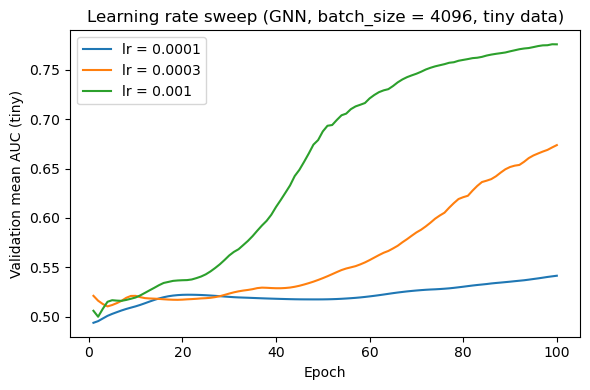

In [10]:
def lr_sweep_on_tiny(
    lrs=(1e-4, 3e-4, 1e-3),
    hidden_dim=128,
    batch_size=4096,
    num_epochs=100,
    seed=0,
):
    """
    For each learning rate:
      - reinitialize the GNN
      - train for num_epochs on the tiny train set
      - record validation mean AUC after each epoch

    Uses global: train_idx, val_idx, edge_index, edge_attr, y_all, train_step, eval_split.
    """
    torch.manual_seed(seed)
    np.random.seed(seed)

    history = {}

    for lr in lrs:
        print(f"\n=== LR sweep: lr = {lr}, batch_size = {batch_size} ===")
        make_gnn_model(hidden_dim=hidden_dim, lr=lr)

        epochs = []
        val_auc_curve = []
        train_auc_curve = []

        for epoch in range(1, num_epochs + 1):
            # one stochastic update on a random minibatch of train_idx
            train_loss_step = train_step(batch_size=batch_size)

            # full train / val evaluation (for monitoring)
            train_loss_eval, train_auc_heads, train_auc_mean = eval_split(
                train_idx, split_name="train"
            )
            val_loss, val_auc_heads, val_auc_mean = eval_split(
                val_idx, split_name="val"
            )

            epochs.append(epoch)
            train_auc_curve.append(float(train_auc_mean))
            val_auc_curve.append(float(val_auc_mean))

            if epoch == 1 or epoch % 10 == 0:
                print(
                    f"Epoch {epoch:3d} | "
                    f"train_loss(step)={train_loss_step:.4f} | "
                    f"train_mean_auc={train_auc_mean:.4f} | "
                    f"val_mean_auc={val_auc_mean:.4f}"
                )

        history[lr] = {
            "epochs": np.array(epochs),
            "train_auc_mean": np.array(train_auc_curve),
            "val_auc_mean": np.array(val_auc_curve),
        }

    return history


# run the sweep on tiny data (gnn_data_tiny.pt)
lrs = [1e-4, 3e-4, 1e-3, 3e-3]
lr_history = lr_sweep_on_tiny(
    lrs=lrs,
    hidden_dim=128,
    batch_size=4096,
    num_epochs=500,
)

# Plot: validation mean AUC vs epoch for each learning rate
plt.figure(figsize=(6, 4))
for lr in lrs:
    h = lr_history[lr]
    plt.plot(
        h["epochs"],
        h["val_auc_mean"],
        label=f"lr = {lr}",
    )

plt.xlabel("Epoch")
plt.ylabel("Validation mean AUC (tiny)")
plt.title("Learning rate sweep (GNN, batch_size = 4096, tiny data)")
plt.legend()
plt.tight_layout()
plt.show()



=== Batch-size sweep: batch_size = 1024, lr = 0.001 ===
Epoch   1 | train_loss(step)=0.7116 | train_mean_auc=0.5130 | val_mean_auc=0.5154
Epoch  10 | train_loss(step)=0.4749 | train_mean_auc=0.5142 | val_mean_auc=0.5168
Epoch  20 | train_loss(step)=0.4589 | train_mean_auc=0.5264 | val_mean_auc=0.5290
Epoch  30 | train_loss(step)=0.4673 | train_mean_auc=0.5521 | val_mean_auc=0.5545
Epoch  40 | train_loss(step)=0.4615 | train_mean_auc=0.5757 | val_mean_auc=0.5776
Epoch  50 | train_loss(step)=0.4423 | train_mean_auc=0.6363 | val_mean_auc=0.6366
Epoch  60 | train_loss(step)=0.4278 | train_mean_auc=0.6800 | val_mean_auc=0.6788
Epoch  70 | train_loss(step)=0.4104 | train_mean_auc=0.7159 | val_mean_auc=0.7143
Epoch  80 | train_loss(step)=0.3968 | train_mean_auc=0.7370 | val_mean_auc=0.7350
Epoch  90 | train_loss(step)=0.3968 | train_mean_auc=0.7467 | val_mean_auc=0.7446
Epoch 100 | train_loss(step)=0.3877 | train_mean_auc=0.7568 | val_mean_auc=0.7548
Epoch 110 | train_loss(step)=0.4037 | tra

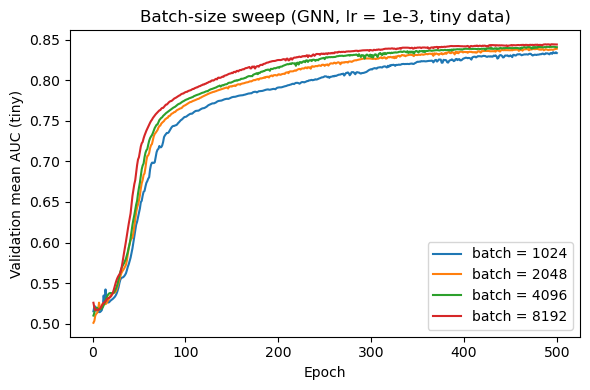

In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Helper: (re)build GNN + optimizer for each run
def make_gnn_model(hidden_dim, lr):
    global model, optimizer, criterion

    model = GNN(
        num_nodes=num_nodes,
        num_edge_features=D_edge,
        hidden_dim=hidden_dim
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()


def batchsize_sweep_on_tiny(
    batch_sizes=(1024, 2048, 4096, 8192),
    hidden_dim=128,
    lr=1e-3,
    num_epochs=100,
    seed=0,
):
    """
    For each batch size:
      - reinitialize the GNN
      - train for num_epochs on the tiny train set
      - record validation mean AUC after each epoch.

    Assumes global:
      train_idx, val_idx, train_step(batch_size), eval_split(idx, split_name).
    """
    torch.manual_seed(seed)
    np.random.seed(seed)

    history = {}

    for bs in batch_sizes:
        print(f"\n=== Batch-size sweep: batch_size = {bs}, lr = {lr} ===")
        make_gnn_model(hidden_dim=hidden_dim, lr=lr)

        epochs = []
        train_auc_curve = []
        val_auc_curve = []

        for epoch in range(1, num_epochs + 1):
            # one stochastic update on a random minibatch of train_idx
            train_loss_step = train_step(batch_size=bs)

            # full train / val evaluation (for monitoring)
            train_loss_eval, train_auc_heads, train_auc_mean = eval_split(
                train_idx, split_name="train"
            )
            val_loss, val_auc_heads, val_auc_mean = eval_split(
                val_idx, split_name="val"
            )

            epochs.append(epoch)
            train_auc_curve.append(float(train_auc_mean))
            val_auc_curve.append(float(val_auc_mean))

            if epoch == 1 or epoch % 10 == 0:
                print(
                    f"Epoch {epoch:3d} | "
                    f"train_loss(step)={train_loss_step:.4f} | "
                    f"train_mean_auc={train_auc_mean:.4f} | "
                    f"val_mean_auc={val_auc_mean:.4f}"
                )

        history[bs] = {
            "epochs": np.array(epochs),
            "train_auc_mean": np.array(train_auc_curve),
            "val_auc_mean": np.array(val_auc_curve),
        }

    return history


# run the sweep on tiny data with lr = 1e-3
batch_sizes = [1024, 2048, 4096, 8192]
bs_history = batchsize_sweep_on_tiny(
    batch_sizes=batch_sizes,
    hidden_dim=128,
    lr=1e-3,
    num_epochs=500,
)

# Plot: validation mean AUC vs epoch for each batch size
plt.figure(figsize=(6, 4))
for bs in batch_sizes:
    h = bs_history[bs]
    plt.plot(
        h["epochs"],
        h["val_auc_mean"],
        label=f"batch = {bs}",
    )

plt.xlabel("Epoch")
plt.ylabel("Validation mean AUC (tiny)")
plt.title("Batch-size sweep (GNN, lr = 1e-3, tiny data)")
plt.legend()
plt.tight_layout()
plt.show()


### 6. Model training

In [9]:
# Model Selection

model = EdgeMLP(num_edge_features=D_edge, hidden_dim=64).to(device)


# model = GNN(
#     num_nodes=num_nodes,
#     num_edge_features=D_edge,
#     hidden_dim=128
# ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()


In [10]:
num_heads = 4
patience = 20
model_name = type(model).__name__

best_val_auc_heads = [-float("inf")] * num_heads
best_val_auc_mean = -float("inf")
best_state = None
best_epoch = None

no_improve_heads = [0] * num_heads

for epoch in range(1, 2001):
    # 1) one training step
    train_loss_step = train_step(batch_size=4096)

    # 2) evaluate on train + val
    train_loss_eval, train_auc_heads, train_auc_mean = eval_split(train_idx, "train")
    val_loss, val_auc_heads, val_auc_mean = eval_split(val_idx, "val")

    # pretty print
    head_str_train = " | ".join(
        [f"h{h}: {train_auc_heads[h]:.4f}" for h in range(num_heads)]
    )
    head_str_val = " | ".join(
        [f"h{h}: {val_auc_heads[h]:.4f}" for h in range(num_heads)]
    )
    print(
        f"Epoch {epoch:03d} | "
        f"train_loss(step) = {train_loss_step:.4f} | "
        f"train_loss(eval) = {train_loss_eval:.4f} | "
        f"train_mean_auc = {train_auc_mean:.4f} | "
        f"val_mean_auc = {val_auc_mean:.4f}"
    )
    print(f"  train AUC per head: {head_str_train}")
    print(f"  val   AUC per head: {head_str_val}")

    # 3) update bests and no_improve counters
    any_head_improved = False
    for h in range(num_heads):
        auc_h = val_auc_heads[h]
        if np.isnan(auc_h):
            # skip heads with undefined AUC
            continue

        if auc_h > best_val_auc_heads[h]:
            best_val_auc_heads[h] = auc_h
            no_improve_heads[h] = 0
            any_head_improved = True
        else:
            no_improve_heads[h] += 1

    # we can still track best mean AUC for logging, but your stopping rule
    # is based on all heads
    if val_auc_mean > best_val_auc_mean:
        best_val_auc_mean = val_auc_mean

    # if any head improved, save model
    if any_head_improved:
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        best_epoch = epoch
        formatted_aucs = [f"{a:.4f}" for a in best_val_auc_heads]
        print(f"  [{model_name}] improvement! best val AUC per head now: {formatted_aucs}")
        print(f"  [{model_name}] best mean val AUC = {best_val_auc_mean:.4f}")
    else:
        print(f"  no improvement this epoch. no_improve_heads = {no_improve_heads}")

    # 4) early stopping: all heads stopped improving for patience epochs
    if all(n >= patience for n in no_improve_heads):
        print("Early stopping triggered: all heads have stalled.")
        break

# After training: reload best model and evaluate
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"\nLoaded best model from epoch {best_epoch}")
    print(f"Best val AUC per head: {best_val_auc_heads}")
    print(f"Best mean val AUC: {best_val_auc_mean:.4f}")
else:
    print("\nWarning: best_state is None")

print("\nRe-evaluating splits with best model:")

train_loss_final, train_auc_heads_final, train_auc_mean_final = eval_split(train_idx, "train")
val_loss_final, val_auc_heads_final, val_auc_mean_final = eval_split(val_idx, "val")
test_loss_final, test_auc_heads_final, test_auc_mean_final = eval_split(test_idx, "test")

print(f"Final train loss: {train_loss_final:.4f} | train mean AUC: {train_auc_mean_final:.4f}")
print(f"  train AUC per head: {train_auc_heads_final}")
print(f"Final val   loss: {val_loss_final:.4f} | val   mean AUC: {val_auc_mean_final:.4f}")
print(f"  val   AUC per head: {val_auc_heads_final}")
print(f"Final test  loss: {test_loss_final:.4f} | test  mean AUC: {test_auc_mean_final:.4f}")
print(f"  test  AUC per head: {test_auc_heads_final}")
print(f"Best epoch used for final eval: {best_epoch}")


Epoch 001 | train_loss(step) = 0.6861 | train_loss(eval) = 0.6595 | train_mean_auc = 0.4907 | val_mean_auc = 0.4918
  train AUC per head: h0: 0.4542 | h1: 0.5215 | h2: 0.4837 | h3: 0.5035
  val   AUC per head: h0: 0.4529 | h1: 0.5247 | h2: 0.4898 | h3: 0.4997
  [GNN] improvement! best val AUC per head now: ['0.4529', '0.5247', '0.4898', '0.4997']
  [GNN] best mean val AUC = 0.4918
Epoch 002 | train_loss(step) = 0.6595 | train_loss(eval) = 0.6338 | train_mean_auc = 0.5019 | val_mean_auc = 0.5045
  train AUC per head: h0: 0.4962 | h1: 0.5213 | h2: 0.4929 | h3: 0.4972
  val   AUC per head: h0: 0.4996 | h1: 0.5255 | h2: 0.4997 | h3: 0.4932
  [GNN] improvement! best val AUC per head now: ['0.4996', '0.5255', '0.4997', '0.4997']
  [GNN] best mean val AUC = 0.5045
Epoch 003 | train_loss(step) = 0.6336 | train_loss(eval) = 0.6087 | train_mean_auc = 0.5027 | val_mean_auc = 0.5052
  train AUC per head: h0: 0.5005 | h1: 0.5159 | h2: 0.4976 | h3: 0.4968
  val   AUC per head: h0: 0.5041 | h1: 0.520

KeyboardInterrupt: 

### 7. Saving output

In [ ]:
SAVE_DIR = Path("/Users/haozhangao/Desktop/RecSys Research/KuaiRec 2.0/models/GNN")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

model_path = SAVE_DIR / f"{model_name}_multihead_best_tiny_test.pt"

torch.save(
    {
        "state_dict": model.state_dict(),
        "best_epoch": best_epoch,

        # best (according to early stopping)
        "best_val_auc_heads": best_val_auc_heads,        # list of 4 floats
        "best_val_auc_mean": best_val_auc_mean,

        # final metrics at best_epoch
        "train_loss_final": float(train_loss_final),
        "val_loss_final": float(val_loss_final),
        "test_loss_final": float(test_loss_final),

        "train_auc_heads_final": train_auc_heads_final,  # list of 4
        "val_auc_heads_final": val_auc_heads_final,      # list of 4
        "test_auc_heads_final": test_auc_heads_final,    # list of 4

        "train_auc_mean_final": float(train_auc_mean_final),
        "val_auc_mean_final": float(val_auc_mean_final),
        "test_auc_mean_final": float(test_auc_mean_final),
    },
    model_path,
)

# pretty print with 4 digits
fmt = lambda xs: " | ".join(f"{x:.4f}" for x in xs)

print(f"Saved best {model_name} (multi-head) model to: {model_path}")
print(f"  best_epoch: {best_epoch}")
print(f"  best val AUC per head: [{fmt(best_val_auc_heads)}]")
print(f"  best val mean AUC: {best_val_auc_mean:.4f}")
print(f"  final train AUC per head: [{fmt(train_auc_heads_final)}], mean = {train_auc_mean_final:.4f}")
print(f"  final val   AUC per head: [{fmt(val_auc_heads_final)}],   mean = {val_auc_mean_final:.4f}")
print(f"  final test  AUC per head: [{fmt(test_auc_heads_final)}],  mean = {test_auc_mean_final:.4f}")
